# Extracting and training Driver Outline

We extract the outline of a stratified random sample of the data to see if a model can predict better if the required features are extracted.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, get_scorer_names
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import torch
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision import transforms
from sklearn.decomposition import PCA

# If you do not have a GPU or do not want to run this code on your GPU, comment out the following lines
torch.cuda.empty_cache()
torch.cuda.is_available()

c:\Users\wamik\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\wamik\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\wamik\miniconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


True

## Extracting the Data

The images stored in the combined dataset are extracted into separate train and test set paths.

NOTE: Before running this file, please unzip the Distacted Driver Dataset that contains the combined dataset.

In [2]:
CLASS = [["c0", "Safe Driving"], ["c1", "Text"], ["c2", "Phone"], 
         ["c3", "Adjusting Radio"], ["c4", "Drinking"], 
         ["c5", "Reaching Behind"], ["c6", "Hair or Makeup"], 
         ["c7", "Talking to Passenger"]]
TEST_CLS = [os.path.join(os.getcwd(), "Distracted Driver Dataset", "Combined", "test", cls[0]) for cls in CLASS]
TRAIN_CLS = [os.path.join(os.getcwd(), "Distracted Driver Dataset", "Combined", "train", cls[0]) for cls in CLASS]
for cls_path in TEST_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))
for cls_path in TRAIN_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))

c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c0
346
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c1
393
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c2
364
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c3
170
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c4
143
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c5
143
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c6
146
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\

For each class, the path of the training and test data is stored in separate lists. The corresponding labels are also stored in a different list

In [3]:
train_paths = []
test_paths = []
for cls in range(8):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    train_paths.append(os.path.join(TRAIN_CLS[cls], train_instance))
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_paths.append(os.path.join(TEST_CLS[cls], test_instance))

In [4]:
classes = []
test_classes = []
for cls in range(8):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    classes.append(cls)
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_classes.append(cls)

Then separate dataframes storing the train and test paths with their corresponding labels are created.

In [5]:
df = pd.DataFrame({
  'filename': train_paths,
  'class': classes
})
df

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
12550,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
12551,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
12552,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
12553,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


In [6]:
df_test = pd.DataFrame({
  'filename': test_paths,
  'class': test_classes
})
df_test

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
1918,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
1919,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
1920,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
1921,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


The below plots show us the frequency of each class in the dataset. As can be seen from the plots, the dataset is not balanced. Keeping this in mind, we use evaluation metrics like recall and precision along with accuracy to get better insights on performance.

<AxesSubplot:>

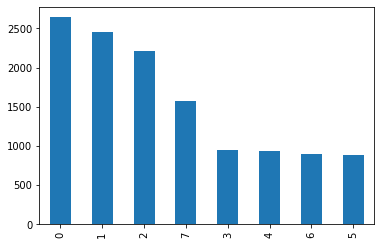

In [7]:
df['class'].value_counts().plot.bar()

<AxesSubplot:>

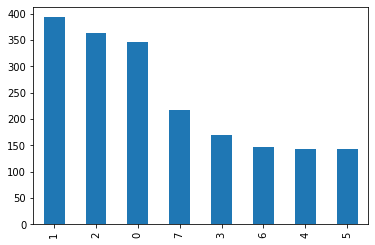

In [8]:
df_test['class'].value_counts().plot.bar()

In [9]:
df_all_data = pd.concat([df, df_test], ignore_index=True)
df_all_data

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
14473,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
14474,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
14475,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
14476,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


## Data Preprocessing

First, we convert the images from RGB to Gray and then perform appropriate resizing based on a calculated scale. Then, we use pytorch's DeeplabV3 neural network to extract the shape of the driver, these are represented as pixels marked true in _mask_. [source](https://v-hramchenko.medium.com/how-to-cut-out-a-person-in-an-image-with-open-source-projects-e5e7f8798d5c)

In [10]:
def make_deeplab(device):
    deeplab = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT).to(device)
    deeplab.eval()
    return deeplab

device = torch.device("cuda") # If you do not have a GPU or do not want to run the code on your GPU, replace "cuda" with "cpu"
deeplab = make_deeplab(device)

In [11]:
deeplab_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def apply_deeplab(deeplab, img, device):
    input_tensor = deeplab_preprocess(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = deeplab(input_batch.to(device))['out'][0]
    # If you do not have a GPU or do not want to run this code on your GPU, replace the next two lines with one line: 
    # output_predictions = output.argmax(0).cpu().numpy()
    output_predictions = output.argmax(0).cuda().to("cpu")
    output_predictions = output_predictions.numpy()
    return (output_predictions == 15)

We first test out our proposed idea on a sample image, the results of which are shown below. It can be seen that the driver is cropped out of the image and the background is removed (set to black).

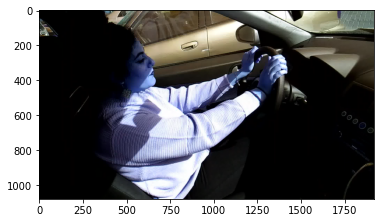

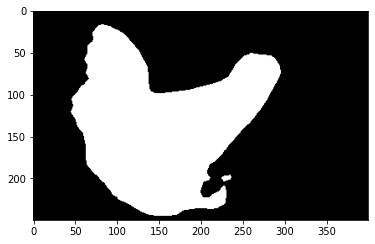

(250, 400, 3)
(250, 400, 3)


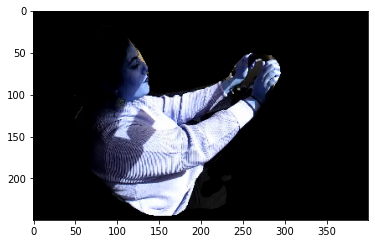

In [29]:
img_orig = cv2.imread(df['filename'].iloc[100], cv2.COLOR_RGB2GRAY)
plt.imshow(img_orig)
plt.show()
k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
img = cv2.resize(img_orig, (400, 250), fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)

# Running the deeplab model on a sample image
mask = apply_deeplab(deeplab, img, device)

plt.imshow(mask, cmap='gray')
plt.show()

# Only choose pixels of the gray image that correspond to true pixels of the mask. Rest are set to rgb 0, 0, 0, i.e., black.
print(np.asarray(img).shape)
img_seg = []
for i in range(len(mask)):
    pixels = []
    for j in range(len(mask[i])):
        if mask[i][j]:
            pixels.append(img[i][j])
        else:
            pixels.append([0, 0, 0])
    img_seg.append(pixels)
    
img_seg = np.asarray(img_seg)
print(img_seg.shape)
plt.imshow(img_seg)

We now perform a similar process on all sets of the training data. Before doing so, we first convert the images into 2D pixels with the appropriate color to gray transformation and resizing. This is done so that the 1255 samples can be randomly selected using _train_test_split()_.

In [31]:
X_train_final = []
Y_test = []
for index, path in df.iterrows():
    img_orig = cv2.imread(path[0], cv2.COLOR_RGB2GRAY)
    k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
    img = cv2.resize(img_orig, (400, 250), fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)
    if (index+1) % 135 == 0:
        print("Processed ", index + 1, "images. Continuing...")
    X_train_final.append(np.asarray(img))
    Y_test.append(path[1])

print("Done!")

Processed  135 images. Continuing...
Processed  270 images. Continuing...
Processed  405 images. Continuing...
Processed  540 images. Continuing...
Processed  675 images. Continuing...
Processed  810 images. Continuing...
Processed  945 images. Continuing...
Processed  1080 images. Continuing...
Processed  1215 images. Continuing...
Processed  1350 images. Continuing...
Processed  1485 images. Continuing...
Processed  1620 images. Continuing...
Processed  1755 images. Continuing...
Processed  1890 images. Continuing...
Processed  2025 images. Continuing...
Processed  2160 images. Continuing...
Processed  2295 images. Continuing...
Processed  2430 images. Continuing...
Processed  2565 images. Continuing...
Processed  2700 images. Continuing...
Processed  2835 images. Continuing...
Processed  2970 images. Continuing...
Processed  3105 images. Continuing...
Processed  3240 images. Continuing...
Processed  3375 images. Continuing...
Processed  3510 images. Continuing...
Processed  3645 ima

In [32]:
print(len(Y_test))

12555


In [33]:
data_arr = np.asarray(X_train_final)
print(data_arr.shape)
# data_arr = data_arr.reshape(data_arr.shape[0], -1)
labels_arr = np.asarray(Y_test)

(12555, 250, 400, 3)


In [34]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data_arr, labels_arr, test_size=0.9, stratify=Y_test, random_state=42)
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
print(X_train.shape)
print(Y_train.shape)

(1255, 250, 400, 3)
(1255,)


We process the data in 2 parts due to processing time and power constraints. Each half is stored in a separate .npy file.

In [35]:
X_train_processed = []
done = 0
for img in X_train[0:627]:
    done+=1
    mask = apply_deeplab(deeplab, img, device)
    # img_seg = []
    # for i in range(len(mask)):
    #     pixels = []
    #     for j in range(len(mask[i])):
    #         if mask[i][j]:
    #             pixels.append(img[i][j])
    #         else:
    #             pixels.append([0, 0, 0])
    #     img_seg.append(pixels)
    X_train_processed.append(mask)
    print("Processed ", done, " images. Continuing...") 

X_train_processed = np.asarray(X_train_processed)
print(X_train_processed.shape)

Processed  1  images. Continuing...
Processed  2  images. Continuing...
Processed  3  images. Continuing...
Processed  4  images. Continuing...
Processed  5  images. Continuing...
Processed  6  images. Continuing...
Processed  7  images. Continuing...
Processed  8  images. Continuing...
Processed  9  images. Continuing...
Processed  10  images. Continuing...
Processed  11  images. Continuing...
Processed  12  images. Continuing...
Processed  13  images. Continuing...
Processed  14  images. Continuing...
Processed  15  images. Continuing...
Processed  16  images. Continuing...
Processed  17  images. Continuing...
Processed  18  images. Continuing...
Processed  19  images. Continuing...
Processed  20  images. Continuing...
Processed  21  images. Continuing...
Processed  22  images. Continuing...
Processed  23  images. Continuing...
Processed  24  images. Continuing...
Processed  25  images. Continuing...
Processed  26  images. Continuing...
Processed  27  images. Continuing...
Processed 

In [36]:
np.save("Data/outline_imgs.npy", X_train_processed)

In [37]:
X_train_processed = []
done = 0
for img in X_train[627:]:
    done+=1
    mask = apply_deeplab(deeplab, img, device)
    # img_seg = []
    # for i in range(len(mask)):
    #     pixels = []
    #     for j in range(len(mask[i])):
    #         if mask[i][j]:
    #             pixels.append(img[i][j])
    #         else:
    #             pixels.append([0, 0, 0])
    #     img_seg.append(pixels)
    X_train_processed.append(mask)
    print("Processed ", done, " images. Continuing...") 

X_train_processed = np.asarray(X_train_processed)
print(X_train_processed.shape)

Processed  1  images. Continuing...
Processed  2  images. Continuing...
Processed  3  images. Continuing...
Processed  4  images. Continuing...
Processed  5  images. Continuing...
Processed  6  images. Continuing...
Processed  7  images. Continuing...
Processed  8  images. Continuing...
Processed  9  images. Continuing...
Processed  10  images. Continuing...
Processed  11  images. Continuing...
Processed  12  images. Continuing...
Processed  13  images. Continuing...
Processed  14  images. Continuing...
Processed  15  images. Continuing...
Processed  16  images. Continuing...
Processed  17  images. Continuing...
Processed  18  images. Continuing...
Processed  19  images. Continuing...
Processed  20  images. Continuing...
Processed  21  images. Continuing...
Processed  22  images. Continuing...
Processed  23  images. Continuing...
Processed  24  images. Continuing...
Processed  25  images. Continuing...
Processed  26  images. Continuing...
Processed  27  images. Continuing...
Processed 

In [38]:
np.save("Data/outline_imgs_1.npy", X_train_processed)
np.save("Data/outline_labels.npy", Y_train)

In [2]:
X_train_1 = np.load("Data/outline_imgs.npy")
X_train_2 = np.load("Data/outline_imgs_1.npy")
Y_train = np.load("Data/outline_labels.npy")
X_train_final = np.concatenate((X_train_1, X_train_2))
# X_train_final = X_train_final.reshape(X_train_final.shape[0], -1)
X_train_final.shape

(1255, 250, 400)

In [3]:
X_train = []
for x in X_train_final:
    x_arr = np.asarray(x)
    x = x_arr.reshape(250, 400, 1)
    X_train.append(x)
X_train = np.asarray(X_train)
X_train.shape

(1255, 250, 400, 1)

## Preparing Test/Validation Data

Test data is prepared in the same manner as the training data. Run this section ONLY ONCE to generate the .npy files.

In [41]:
X_test_processed = []
Y_test = []
for index, path in df_test.iterrows():
    img_orig = cv2.imread(path[0], cv2.COLOR_RGB2GRAY)
    k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
    img = cv2.resize(img_orig, (400, 250), fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)
    if (index+1) % 135 == 0:
        print("Processed ", index + 1, "images. Continuing...")
    X_test_processed.append(np.asarray(img))
    Y_test.append(path[1])

print("Done!")

Processed  135 images. Continuing...
Processed  270 images. Continuing...
Processed  405 images. Continuing...
Processed  540 images. Continuing...
Processed  675 images. Continuing...
Processed  810 images. Continuing...
Processed  945 images. Continuing...
Processed  1080 images. Continuing...
Processed  1215 images. Continuing...
Processed  1350 images. Continuing...
Processed  1485 images. Continuing...
Processed  1620 images. Continuing...
Processed  1755 images. Continuing...
Processed  1890 images. Continuing...
Done!


In [42]:
tdata_arr = np.asarray(X_test_processed)
print(tdata_arr.shape)
# data_arr = data_arr.reshape(data_arr.shape[0], -1)
tlabels_arr = np.asarray(Y_test)

(1923, 250, 400, 3)


In [43]:
(X_train_nouse, X_test, Y_train_nouse, Y_test) = train_test_split(tdata_arr, tlabels_arr, test_size=0.1, stratify=tlabels_arr, random_state=42)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
print(X_test.shape)
print(Y_test.shape)

(193, 250, 400, 3)
(193,)


In [44]:
X_test_processed = []
done = 0
for img in X_test:
    done+=1
    mask = apply_deeplab(deeplab, img, device)
    # img_seg = []
    # for i in range(len(mask)):
    #     pixels = []
    #     for j in range(len(mask[i])):
    #         if mask[i][j]:
    #             pixels.append(img[i][j])
    #         else:
    #             pixels.append([0, 0, 0])
    #     img_seg.append(pixels)
    mask = mask.reshape(250, 400, 1)
    X_test_processed.append(mask)
    print("Processed ", done, " images. Continuing...") 

X_test_processed = np.asarray(X_test_processed)
# X_test_processed = X_test_processed.reshape(X_test_processed.shape[0], -1)
print(X_test_processed.shape)

Processed  1  images. Continuing...
Processed  2  images. Continuing...
Processed  3  images. Continuing...
Processed  4  images. Continuing...
Processed  5  images. Continuing...
Processed  6  images. Continuing...
Processed  7  images. Continuing...
Processed  8  images. Continuing...
Processed  9  images. Continuing...
Processed  10  images. Continuing...
Processed  11  images. Continuing...
Processed  12  images. Continuing...
Processed  13  images. Continuing...
Processed  14  images. Continuing...
Processed  15  images. Continuing...
Processed  16  images. Continuing...
Processed  17  images. Continuing...
Processed  18  images. Continuing...
Processed  19  images. Continuing...
Processed  20  images. Continuing...
Processed  21  images. Continuing...
Processed  22  images. Continuing...
Processed  23  images. Continuing...
Processed  24  images. Continuing...
Processed  25  images. Continuing...
Processed  26  images. Continuing...
Processed  27  images. Continuing...
Processed 

In [45]:
# X_test_final = pca.transform(X_test_processed)
np.save("Data/outline_test_imgs.npy", X_test_processed)
np.save("Data/outline_test_labels.npy", Y_test)

In [4]:
X_test_processed = np.load("Data/outline_test_imgs.npy")
Y_test = np.load("Data/outline_test_labels.npy")
X_test_processed.shape

(193, 250, 400, 1)

In [5]:
from keras.utils import np_utils

Y_train_resized = np_utils.to_categorical(Y_train, 8)
print('New y_train shape: ', Y_train_resized.shape)

Y_val_resized = np_utils.to_categorical(Y_test, 8)
print('New y_train shape: ', Y_val_resized.shape)

New y_train shape:  (1255, 8)
New y_train shape:  (193, 8)


In [14]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides = (2, 2) , activation='relu', input_shape=(250, 400, 1)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 123, 198, 32)      832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 45, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 9, 18, 32)         51232     
                                                                 
 global_average_pooling2d_3   (None, 32)              

In [15]:
import keras

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
]

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 50
EPOCHS = 100

history = model.fit(X_train, Y_train_resized, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=callbacks_list,
                    validation_data=(X_test_processed, Y_val_resized))

Epoch 1/100
26/26 [==============================] - 3s 111ms/step - loss: 2.0276 - accuracy: 0.1657 - val_loss: 1.9992 - val_accuracy: 0.2021
Epoch 2/100
26/26 [==============================] - 3s 105ms/step - loss: 2.0077 - accuracy: 0.2016 - val_loss: 2.0072 - val_accuracy: 0.1813
Epoch 3/100
26/26 [==============================] - 3s 105ms/step - loss: 1.9908 - accuracy: 0.2223 - val_loss: 1.9975 - val_accuracy: 0.1917
Epoch 4/100
26/26 [==============================] - 3s 107ms/step - loss: 1.9901 - accuracy: 0.2064 - val_loss: 1.9927 - val_accuracy: 0.1865
Epoch 5/100
26/26 [==============================] - 3s 104ms/step - loss: 1.9804 - accuracy: 0.2104 - val_loss: 1.9810 - val_accuracy: 0.2021
Epoch 6/100
26/26 [==============================] - 3s 106ms/step - loss: 1.9524 - accuracy: 0.2287 - val_loss: 1.9692 - val_accuracy: 0.2228
Epoch 7/100
26/26 [==============================] - 3s 108ms/step - loss: 1.9460 - accuracy: 0.2359 - val_loss: 1.9671 - val_accuracy: 0.2228

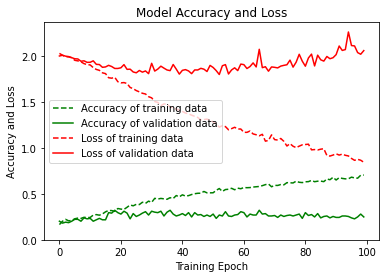

In [16]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [17]:
score = model.evaluate(X_test_processed, Y_val_resized, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

7/7 [==============================] - 1s 40ms/step - loss: 2.0578 - accuracy: 0.2487

Accuracy on test data: 0.25

Loss on test data: 2.06


In [18]:
from sklearn import metrics
import seaborn as sns

LABELS = [0, 1, 2, 3, 4, 5, 6, 7]

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

7/7 [==============================] - 0s 27ms/step


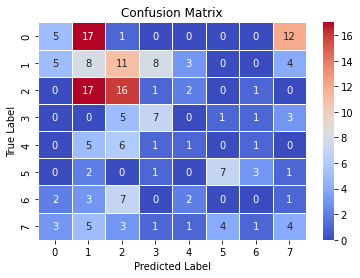


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.33      0.14      0.20        35
           1       0.14      0.21      0.17        39
           2       0.33      0.43      0.37        37
           3       0.37      0.41      0.39        17
           4       0.11      0.07      0.09        14
           5       0.58      0.50      0.54        14
           6       0.00      0.00      0.00        15
           7       0.16      0.18      0.17        22

    accuracy                           0.25       193
   macro avg       0.25      0.24      0.24       193
weighted avg       0.25      0.25      0.24       193



In [19]:
y_pred_test = model.predict(X_test_processed)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_val_resized, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))